# Importing modules

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from playsound import playsound
import pygame
import pandas as pd
import os
import glob
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from io import BytesIO
import requests

pygame 2.5.0 (SDL 2.28.0, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


C:\Users\salha\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Facial landmark detection and most important 6 landmarks position

In [2]:
mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates
%matplotlib inline

In [3]:
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs)) 
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)
# P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

# Load the image for test

In [4]:
def load_img(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape
    return(image)


In [5]:
image =load_img("test01.jpg")

In [6]:
imgH, imgW, _=image.shape

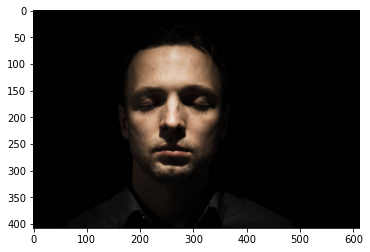

In [7]:
plt.imshow(image)

# Indicates whether any detections are available or not.

In [8]:
def detection_avail(image):
    with mp_facemesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.6,  
    min_tracking_confidence=0.6,   
) as face_mesh:

     
        results = face_mesh.process(image)
        return (results)

In [9]:
results=detection_avail(image)

In [10]:
print(bool(results.multi_face_landmarks))

True


# Landmarks position

In [11]:
def landmarks_position(results):
    landmark_0 = results.multi_face_landmarks[0].landmark[0]
    print(landmark_0)
 
    landmark_0_x = landmark_0.x * imgW 
    landmark_0_y = landmark_0.y * imgH
    landmark_0_z = landmark_0.z * imgW 
 
    print()
    print("X:", landmark_0_x)
    print("Y:", landmark_0_y)
    print("Z:", landmark_0_z)
 
    print()
    print("Total Length of '.landmark':", len(results.multi_face_landmarks[0].landmark))


In [12]:
 landmarks_position(results)

x: 0.42553475499153137
y: 0.6291825175285339
z: -0.043990977108478546


X: 260.4272700548172
Y: 256.70646715164185
Z: -26.92247799038887

Total Length of '.landmark': 478


# Visualization function

In [13]:
def plot(
    *,
    img_dt,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    image_drawing_tool = img_dt 
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness, 
        circle_radius=ts_circle_radius, 
        color=(255, 255, 255)
    )
    fig = plt.figure(figsize=(20, 15))
    fig.set_facecolor("white")
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )

    landmarks = face_landmarks.landmark
 
    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(image_eye_lmks, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )
 
        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )

    plt.subplot(1, 3, 3)
    plt.imshow(img_eye_lmks_chosen)
    plt.title("Chosen landmarks", fontsize=18)
    plt.axis("off")
    plt.show()
    plt.close()
    return

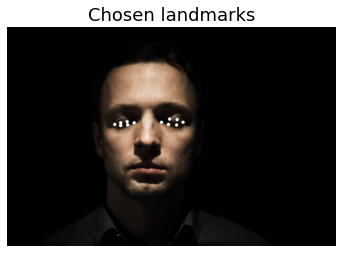

In [14]:
if bool(results.multi_face_landmarks): 
    for face_id, face_landmarks in enumerate(results.multi_face_landmarks):    
        _ = plot(img_dt=image.copy(), face_landmarks=face_landmarks)

# The Eye Aspect Ratio (EAR) 

In [15]:
def distance(point_1, point_2):
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist

In [16]:
def get_ear(landmarks, refer_idxs, frame_width, frame_height):
   
    try:
        
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y, 
                                             frame_width, frame_height)
            coords_points.append(coord)
 
        
        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])
 
        
        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)
 
    except:
        ear = 0.0
        coords_points = None
 
    return ear, coords_points

In [17]:
def calculate_avg_ear(landmarks, left_eye_idxs, right_eye_idxs, image_w, image_h):
 
    left_ear, left_lm_coordinates = get_ear(
                                      landmarks, 
                                      left_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    right_ear, right_lm_coordinates = get_ear(
                                      landmarks, 
                                      right_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    Avg_EAR = (left_ear + right_ear) / 2.0
 
    return Avg_EAR, (left_lm_coordinates, right_lm_coordinates)

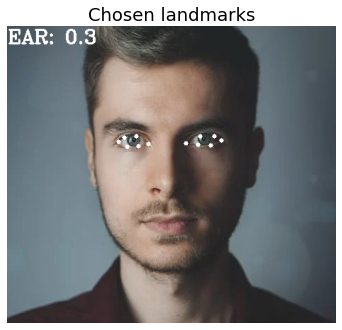

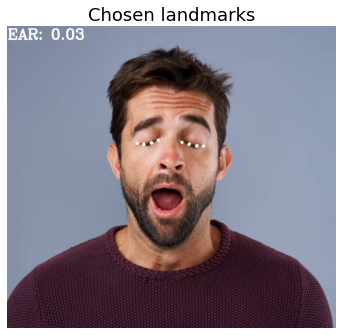

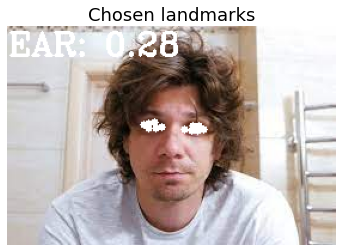

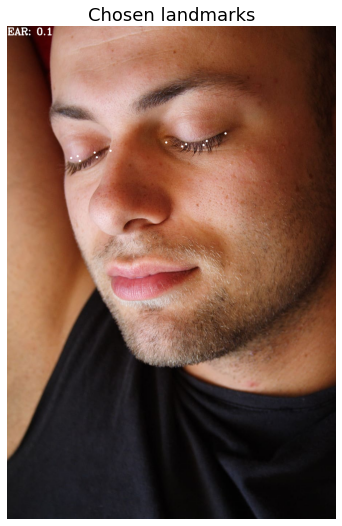

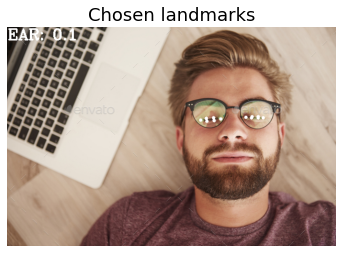

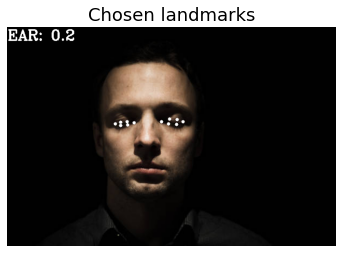

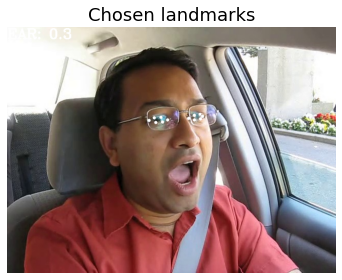

In [18]:
image_eyes_open  = cv2.imread("test.png")[:, :, ::-1]
img1  = cv2.imread("1.jpg")[:, :, ::-1]
img2  = cv2.imread("2.jpg")[:, :, ::-1]
img3  = cv2.imread("test2.jpg")[:, :, ::-1]
img4  = cv2.imread("test3.jpg")[:, :, ::-1]
img5  = cv2.imread("test01.jpg")[:, :, ::-1]
img6  = cv2.imread("test02.jpg")[:, :, ::-1]



for idx, image in enumerate([image_eyes_open, img1 , img2, img3, img4, img5, img6]):
    
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape
 
    
    custom_chosen_lmk_image = image.copy()
 
    
    with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
        results = face_mesh.process(image).multi_face_landmarks
 
      
        if results:
            for face_id, face_landmarks in enumerate(results):
                landmarks = face_landmarks.landmark
                EAR, _ = calculate_avg_ear(
                          landmarks, 
                          chosen_left_eye_idxs, 
                          chosen_right_eye_idxs, 
                          imgW, 
                          imgH
                )
 
                # Print the EAR value on the custom_chosen_lmk_image.
                cv2.putText(custom_chosen_lmk_image, 
                            f"EAR: {round(EAR, 2)}", (1, 24),
                            cv2.FONT_HERSHEY_COMPLEX, 
                            0.9, (255, 255, 255), 2
                )                
              
                plot(img_dt=image.copy(),
                     img_eye_lmks_chosen=custom_chosen_lmk_image,
                     face_landmarks=face_landmarks,
                     ts_thickness=1, 
                     ts_circle_radius=2, 
                     lmk_circle_radius=3
                )

# Evaluation #######

# Build a Dataframe whose classification is done with the model

In [19]:
ev=[]
img_ev=[]

In [20]:
drowsy_imgs = 'C:\\Users\\salha\\Downloads\\archive\\train\\yawn'
no_drowsy_imgs = 'C:\\Users\\salha\\Downloads\\archive\\train\\no_yawn'
drowsy_path = glob.glob(os.path.join(drowsy_imgs, '*.jpg'))
no_drowsy_path = glob.glob(os.path.join(no_drowsy_imgs, '*.jpg'))

In [21]:
drowsy_image_names = [os.path.basename(path) for path in drowsy_path]
no_drowsy_image_names = [os.path.basename(path) for path in no_drowsy_path]

In [22]:
for chemin in drowsy_path:
    image = cv2.imread(chemin)
    image = np.ascontiguousarray(image)
    with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
        results = face_mesh.process(image).multi_face_landmarks
 
      
        if results:
            for face_id, face_landmarks in enumerate(results):
                landmarks = face_landmarks.landmark
                EAR, _ = calculate_avg_ear(
                          landmarks, 
                          chosen_left_eye_idxs, 
                          chosen_right_eye_idxs, 
                          imgW, 
                          imgH
                )
                if EAR <= 0.2:
                    ev.append("drowsy")
                else:
                    ev.append("nodrowsy")
    
    

In [23]:
for chemin in no_drowsy_path:
    image = cv2.imread(chemin)
    image = np.ascontiguousarray(image)
    with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
        results = face_mesh.process(image).multi_face_landmarks
 
      
        if results:
            for face_id, face_landmarks in enumerate(results):
                landmarks = face_landmarks.landmark
                EAR, _ = calculate_avg_ear(
                          landmarks, 
                          chosen_left_eye_idxs, 
                          chosen_right_eye_idxs, 
                          imgW, 
                          imgH
                )
                if EAR <= 0.2:
                    ev.append("drowsy")
                else:
                    ev.append("nodrowsy")
    
    

# Build a Dataframe with true classification

In [24]:
drowsy_imgs = 'C:\\Users\\salha\\Downloads\\archive\\train\\yawn'
no_drowsy_imgs ='C:\\Users\\salha\\Downloads\\archive\\train\\no_yawn'
drowsy_path = glob.glob(os.path.join(drowsy_imgs, '*.jpg'))
no_drowsy_path = glob.glob(os.path.join(no_drowsy_imgs, '*.jpg'))

In [25]:
drowsy_image_names = [os.path.basename(path) for path in drowsy_path]
no_drowsy_image_names = [os.path.basename(path) for path in no_drowsy_path]

In [26]:
liste = drowsy_image_names + no_drowsy_image_names

In [27]:
a=len(drowsy_image_names)
b=len(no_drowsy_image_names)

In [28]:
word = "drowsy"
drowsy_series = pd.Series([word] * a)

In [29]:
type(drowsy_series)

pandas.core.series.Series

In [30]:
drowsy_series

0      drowsy
1      drowsy
2      drowsy
3      drowsy
4      drowsy
        ...  
718    drowsy
719    drowsy
720    drowsy
721    drowsy
722    drowsy
Length: 723, dtype: object

In [31]:
word = "nodrowsy"
nodrowsy_series = pd.Series([word] * b)

In [32]:
nodrowsy_series

0      nodrowsy
1      nodrowsy
2      nodrowsy
3      nodrowsy
4      nodrowsy
         ...   
720    nodrowsy
721    nodrowsy
722    nodrowsy
723    nodrowsy
724    nodrowsy
Length: 725, dtype: object

In [33]:
concatenated_series = pd.concat([drowsy_series, nodrowsy_series], ignore_index=True)


In [34]:
concatenated_series

0         drowsy
1         drowsy
2         drowsy
3         drowsy
4         drowsy
          ...   
1443    nodrowsy
1444    nodrowsy
1445    nodrowsy
1446    nodrowsy
1447    nodrowsy
Length: 1448, dtype: object

In [35]:
liste

['drowsy (1).jpg',
 'drowsy (10).jpg',
 'drowsy (100).jpg',
 'drowsy (101).jpg',
 'drowsy (102).jpg',
 'drowsy (103).jpg',
 'drowsy (104).jpg',
 'drowsy (105).jpg',
 'drowsy (106).jpg',
 'drowsy (107).jpg',
 'drowsy (108).jpg',
 'drowsy (109).jpg',
 'drowsy (11).jpg',
 'drowsy (110).jpg',
 'drowsy (111).jpg',
 'drowsy (112).jpg',
 'drowsy (113).jpg',
 'drowsy (114).jpg',
 'drowsy (115).jpg',
 'drowsy (116).jpg',
 'drowsy (117).jpg',
 'drowsy (118).jpg',
 'drowsy (119).jpg',
 'drowsy (12).jpg',
 'drowsy (120).jpg',
 'drowsy (121).jpg',
 'drowsy (122).jpg',
 'drowsy (123).jpg',
 'drowsy (124).jpg',
 'drowsy (125).jpg',
 'drowsy (126).jpg',
 'drowsy (127).jpg',
 'drowsy (128).jpg',
 'drowsy (129).jpg',
 'drowsy (13).jpg',
 'drowsy (130).jpg',
 'drowsy (131).jpg',
 'drowsy (132).jpg',
 'drowsy (133).jpg',
 'drowsy (134).jpg',
 'drowsy (135).jpg',
 'drowsy (136).jpg',
 'drowsy (137).jpg',
 'drowsy (138).jpg',
 'drowsy (139).jpg',
 'drowsy (14).jpg',
 'drowsy (140).jpg',
 'drowsy (141).jpg',

In [36]:
len(liste)

1448

In [37]:
len(ev)

1427

In [38]:
ev = ev + [float('nan')] * 21

In [39]:
df = pd.DataFrame({'Picture': liste, 'Class': concatenated_series, 'Predicted_class':ev})

In [40]:
df = df.fillna('')


In [41]:
df

,Picture,Class,Predicted_class
0,drowsy (1).jpg,drowsy,nodrowsy
1,drowsy (10).jpg,drowsy,nodrowsy
2,drowsy (100).jpg,drowsy,nodrowsy
3,drowsy (101).jpg,drowsy,nodrowsy
4,drowsy (102).jpg,drowsy,nodrowsy
...,...,...,...
1443,no_drowsy (95).jpg,nodrowsy,
1444,no_drowsy (96).jpg,nodrowsy,
1445,no_drowsy (97).jpg,nodrowsy,
1446,no_drowsy (98).jpg,nodrowsy,


In [42]:
df_test = df.drop('Predicted_class', axis=1)

In [43]:
df_test

,Picture,Class
0,drowsy (1).jpg,drowsy
1,drowsy (10).jpg,drowsy
2,drowsy (100).jpg,drowsy
3,drowsy (101).jpg,drowsy
4,drowsy (102).jpg,drowsy
...,...,...
1443,no_drowsy (95).jpg,nodrowsy
1444,no_drowsy (96).jpg,nodrowsy
1445,no_drowsy (97).jpg,nodrowsy
1446,no_drowsy (98).jpg,nodrowsy


# The new dataframe

In [44]:
df

,Picture,Class,Predicted_class
0,drowsy (1).jpg,drowsy,nodrowsy
1,drowsy (10).jpg,drowsy,nodrowsy
2,drowsy (100).jpg,drowsy,nodrowsy
3,drowsy (101).jpg,drowsy,nodrowsy
4,drowsy (102).jpg,drowsy,nodrowsy
...,...,...,...
1443,no_drowsy (95).jpg,nodrowsy,
1444,no_drowsy (96).jpg,nodrowsy,
1445,no_drowsy (97).jpg,nodrowsy,
1446,no_drowsy (98).jpg,nodrowsy,


In [45]:
y_test=df['Class']
predicted_labels=df['Predicted_class']

In [46]:
accuracy = accuracy_score(y_test, predicted_labels)


# Accuracy

In [47]:
accuracy

0.5732044198895028

# Other eval

In [48]:
precision = precision_score(y_test, predicted_labels, average='macro')  
recall = recall_score(y_test, predicted_labels, average='macro')
f1 = f1_score(y_test, predicted_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)








Precision: 0.46430098904036354
Recall: 0.38180378690322886
F1-Score: 0.3418276693195321


C:\Users\salha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Confusion Matrix

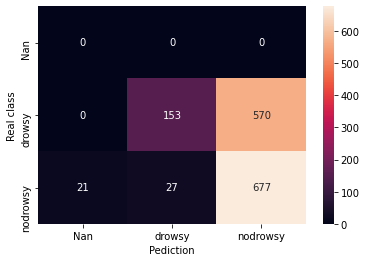

In [49]:
class_names=['Nan','drowsy', 'nodrowsy']
cm = confusion_matrix(y_test, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d',  xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Pediction')
plt.ylabel('Real class')
plt.show()



# Classification Report

In [50]:
class_report = classification_report(y_test, predicted_labels)
class_report = '\n'.join([line for line in class_report.split('\n') if line.strip()])
print(class_report)

              precision    recall  f1-score   support
                   0.00      0.00      0.00         0
      drowsy       0.85      0.21      0.34       723
    nodrowsy       0.54      0.93      0.69       725
    accuracy                           0.57      1448
   macro avg       0.46      0.38      0.34      1448
weighted avg       0.70      0.57      0.51      1448


C:\Users\salha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TEST on video stream:


In [19]:
cap = cv2.VideoCapture(0)
EAR_THRESHOLD = 0.2
ALARM_ON = False 
pygame.mixer.init()

while True:
    success, img = cap.read()
    if not success:
        break

    imgH, imgW, _ = img.shape
    with mp_facemesh.FaceMesh(min_detection_confidence=0.6, min_tracking_confidence=0.6) as face_mesh:
        results = face_mesh.process(img).multi_face_landmarks
        
        for idx in chosen_left_eye_idxs + chosen_right_eye_idxs:
            if results:
                for face_landmarks in results:
                    landmark = face_landmarks.landmark[idx]
                    x = int(landmark.x * imgW)
                    y = int(landmark.y * imgH)
                    cv2.circle(img, (x, y), 1, (255, 255, 255), -1)

        if results:
            for face_landmarks in results:
                landmarks = face_landmarks.landmark
                EAR, _ = calculate_avg_ear(
                    landmarks, 
                    chosen_left_eye_idxs, 
                    chosen_right_eye_idxs, 
                    imgW, 
                    imgH
                )
                
                if EAR < EAR_THRESHOLD and not ALARM_ON:
                    pygame.mixer.music.load('alarm.mp3')
                    pygame.mixer.music.play(-1)
                    ALARM_ON = True
                elif EAR >= EAR_THRESHOLD and ALARM_ON:
                        pygame.mixer.music.stop()
                        ALARM_ON = False  

                cv2.putText(img, 
                            f"EAR: {round(EAR, 2)}", (1, 24),
                            cv2.FONT_HERSHEY_COMPLEX, 
                            0.9, (0, 0, 0), 2)
                
    cv2.imshow('Video', img)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

# Test on ESP32

In [ ]:


EAR_THRESHOLD = 0.2
ALARM_ON = False
pygame.mixer.init()

camera_url = 'http://192.168.1.110/cam-hi.jpg'

while True:
    try:
        response = requests.get(camera_url)
        img_bytes = BytesIO(response.content)
        img_array = np.asarray(bytearray(img_bytes.read()), dtype=np.uint8)
        img = cv2.imdecode(img_array, -1)

        imgH, imgW, _ = img.shape
        with mp_facemesh.FaceMesh(min_detection_confidence=0.6, min_tracking_confidence=0.6) as face_mesh:
            results = face_mesh.process(img).multi_face_landmarks

            for idx in chosen_left_eye_idxs + chosen_right_eye_idxs:
                if results:
                    for face_landmarks in results:
                        landmark = face_landmarks.landmark[idx]
                        x = int(landmark.x * imgW)
                        y = int(landmark.y * imgH)
                        cv2.circle(img, (x, y), 1, (255, 255, 255), -1)

            if results:
                for face_landmarks in results:
                    landmarks = face_landmarks.landmark
                    EAR, _ = calculate_avg_ear(
                        landmarks,
                        chosen_left_eye_idxs,
                        chosen_right_eye_idxs,
                        imgW,
                        imgH
                    )

                    if EAR < EAR_THRESHOLD and not ALARM_ON:
                        pygame.mixer.music.load('alarm.mp3')
                        pygame.mixer.music.play(-1)
                        ALARM_ON = True
                    elif EAR >= EAR_THRESHOLD and ALARM_ON:
                        pygame.mixer.music.stop()
                        ALARM_ON = False

                    cv2.putText(img,
                                f"EAR: {round(EAR, 2)}", (1, 24),
                                cv2.FONT_HERSHEY_COMPLEX,
                                0.9, (0, 0, 0), 2)

        cv2.imshow('Video', img)
        cv2.moveWindow('Video', 0, 0)

        if cv2.waitKey(1) & 0xFF == 27:
            break

    except Exception as e:
        print(f"Error while retrieving image from ESP32 camera: {str(e)}")

cv2.destroyAllWindows()
